# Homework 3 – SVM vs Decision Trees

In [2]:

# Import required libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt


In [ ]:

# dataset
print("Loading Bank Marketing dataset...")
from ucimlrepo import fetch_ucirepo

bm = fetch_ucirepo(id=222)
X = bm.data.features.copy()
y = bm.data.targets.copy()
df = pd.concat([X, y], axis=1)

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    if col != 'y':
        df[col] = LabelEncoder().fit_transform(df[col])
df['y'] = df['y'].map({'no': 0, 'yes': 1})

# Split data
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training size: {X_train.shape}, Test size: {X_test.shape}")
print("Target distribution:", y_train.value_counts(normalize=True).to_dict())


Loading Bank Marketing dataset...
Training size: (36168, 16), Test size: (9043, 16)
Target distribution: {0: 0.8830181375801813, 1: 0.11698186241981863}


In [ ]:
# Helper function evaluate and print metrics
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    if auc is not None:
        print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: {auc:.4f}\n")
    else:
        print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: N/A\n")

    return {"name": name, "accuracy": acc, "f1": f1, "auc": auc}


In [ ]:
# Simplified SVM comparison 
results = []

# Linear SVM
svm_lin = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear', C=1, probability=True, random_state=42))
])
results.append(evaluate_model("SVM (linear, C=1)", svm_lin, X_train, X_test, y_train, y_test))

# RBF SVM
svm_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42))
])
results.append(evaluate_model("SVM (rbf, C=1, gamma=scale)", svm_rbf, X_train, X_test, y_train, y_test))

# Polynomial SVM (for variety)
svm_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='poly', C=1, degree=2, gamma='scale', probability=True, random_state=42))
])
results.append(evaluate_model("SVM (poly, deg=2)", svm_poly, X_train, X_test, y_train, y_test))

print("SVM variants evaluated successfully.")


Running simplified SVM comparisons (no GridSearch)...
=== SVM (linear, C=1) ===
              precision    recall  f1-score   support

           0     0.8830    1.0000    0.9379      7985
           1     0.0000    0.0000    0.0000      1058

    accuracy                         0.8830      9043
   macro avg     0.4415    0.5000    0.4689      9043
weighted avg     0.7797    0.8830    0.8281      9043

Accuracy: 0.8830 | F1: 0.0000 | ROC-AUC: 0.8598

=== SVM (rbf, C=1, gamma=scale) ===
              precision    recall  f1-score   support

           0     0.9093    0.9815    0.9440      7985
           1     0.6509    0.2609    0.3725      1058

    accuracy                         0.8972      9043
   macro avg     0.7801    0.6212    0.6582      9043
weighted avg     0.8790    0.8972    0.8771      9043

Accuracy: 0.8972 | F1: 0.3725 | ROC-AUC: 0.8543

=== SVM (poly, deg=2) ===
              precision    recall  f1-score   support

           0     0.8891    0.9946    0.9389      79

In [ ]:

# Compare with Homework #2
print("Running Decision Tree, Random Forest, AdaBoost for comparison...\n")

dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42)

results.append(evaluate_model("DecisionTree", dt, X_train, X_test, y_train, y_test))
results.append(evaluate_model("RandomForest (100)", rf, X_train, X_test, y_train, y_test))
results.append(evaluate_model("AdaBoost (100, lr=0.5)", ada, X_train, X_test, y_train, y_test))

res_df = pd.DataFrame(results).sort_values(by='accuracy', ascending=False).reset_index(drop=True)
print("result")
display(res_df)

# Save results
res_df.to_csv("HW3_SVM_Comparison_Results.csv", index=False)


Running Decision Tree, Random Forest, AdaBoost for comparison...

=== DecisionTree ===
              precision    recall  f1-score   support

           0     0.9309    0.9296    0.9303      7985
           1     0.4743    0.4792    0.4767      1058

    accuracy                         0.8769      9043
   macro avg     0.7026    0.7044    0.7035      9043
weighted avg     0.8775    0.8769    0.8772      9043

Accuracy: 0.8769 | F1: 0.4767 | ROC-AUC: 0.7044

=== RandomForest (100) ===
              precision    recall  f1-score   support

           0     0.9263    0.9712    0.9482      7985
           1     0.6572    0.4168    0.5101      1058

    accuracy                         0.9063      9043
   macro avg     0.7918    0.6940    0.7292      9043
weighted avg     0.8948    0.9063    0.8970      9043

Accuracy: 0.9063 | F1: 0.5101 | ROC-AUC: 0.9246

=== AdaBoost (100, lr=0.5) ===
              precision    recall  f1-score   support

           0     0.9063    0.9778    0.9407     

,name,accuracy,f1,auc
0,RandomForest (100),0.906336,0.510121,0.924555
1,"SVM (rbf, C=1, gamma=scale)",0.897158,0.372470,0.854326
2,"AdaBoost (100, lr=0.5)",0.891187,0.337820,0.894448
3,"SVM (poly, deg=2)",0.885657,0.114726,0.796220
4,"SVM (linear, C=1)",0.883003,0.000000,0.859757
5,DecisionTree,0.876921,0.476728,0.704412


Results saved to HW3_SVM_Comparison_Results.csv


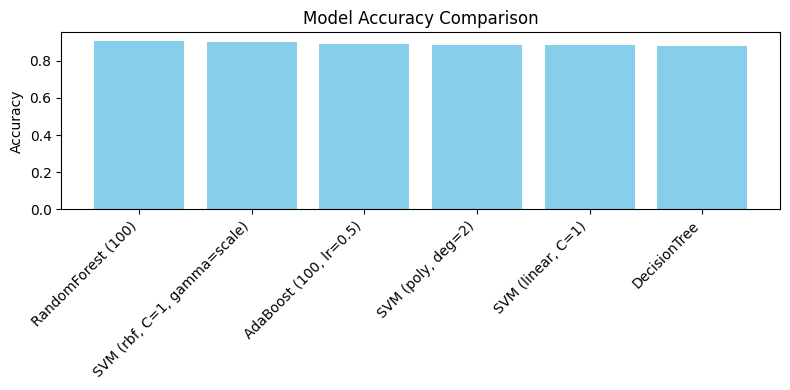

In [9]:

# Simple accuracy comparison plot
plt.figure(figsize=(8,4))
plt.bar(res_df['name'], res_df['accuracy'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()
